Universidad del Valle de Guatemala - 22/07/2022

Jose Abrahama Gutierrez Corado - 19111 <br>
Walter Danilo Saldaña - 19897 <br>
Javier Alejandro Cotto Argueta -19324


# Laboratorio 2 - Datos para Guatemala
## Series de tiempo
______________________________________________________


Importar módulos

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import seaborn as sns
from multiprocessing import cpu_count
from joblib import delayed
from prophet import *

import import_ipynb
from TS import *

## Carga de datos

In [10]:
df = pd.read_csv('./GlobalLandTemperaturesByCountry.csv')
df = df[df["Country"] == 'Guatemala']
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
218067,1825-01-01,21.204,1.770,Guatemala
218068,1825-02-01,21.584,1.374,Guatemala
218069,1825-03-01,23.038,1.704,Guatemala
218070,1825-04-01,25.276,1.923,Guatemala
218071,1825-05-01,24.995,1.276,Guatemala


## 1. Análisis exploratorio

### Descripción del dataset
Representa las temperaturas promedio mensuales, desde 1750, para muchos lugares del mundo. El documento de donde se extrajo la información lo puede encontrar en el siguiente vínculo: http://berkeleyearth.org/data/

### Detalle de las variables

|Variable                      |Detalle|Clasificación|
|:-----------------------------|:------|:------------|
|dt                            |Date time. Mes y año de la medición|Cualitativa ordinal|
|AverageTemperature            |Temperatura promedio en el mes y año indicado por dt|Cuantitativa continua|
|AverageTemperatureUncertainty |Incertidumbre de la medición de temperatura|Cuantitativa continua|
|Country                       |País dónde se realizó la medición|Cualitativa nominal|


### Resúmen estadístico del dataset

In [11]:
df.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,2226.000000,2226.000000
mean,23.111650,0.771264
std,1.631856,0.542986
min,18.232000,0.100000
25%,21.829750,0.336000
50%,23.498500,0.591500
75%,24.383750,1.118000
max,26.665000,3.822000


### Limpieza de datos
#### Datos incompletos
Las series de datos que no tienen valor para la variable `AverageTemperature` no aportan información para el análisis, por lo cual se descartan.

In [12]:
df['AverageTemperature'].isnull().sum()

39

In [13]:
df = df.dropna(subset=['AverageTemperature'])
df['AverageTemperature'].isnull().sum()

0

A fines prácticos se aproximará a 0 la incertidumbre (`AverageTemperatureUncertainty`) de las filas que no tengan información de la misma.

In [14]:
df['AverageTemperatureUncertainty'] = df['AverageTemperatureUncertainty'].fillna(0)
df['AverageTemperatureUncertainty'].isnull().sum()

0

#### Datos atípicos
Se analizan los datos atípicos de la variable `AverageTemperature`.

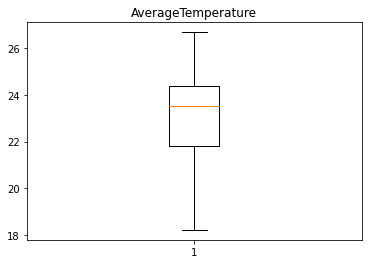

In [15]:
plt.boxplot(df['AverageTemperature'])
plt.title('AverageTemperature')
plt.show()

In [16]:
Q1 = df['AverageTemperature'].quantile(0.25)
Q3 = df['AverageTemperature'].quantile(0.75)
IQR = Q3 - Q1

inferior = df[df['AverageTemperature'] < (Q1 - 1.5 * IQR)]
superior = df[df['AverageTemperature'] > (Q3 + 1.5 * IQR)]

In [17]:
len(inferior)

0

In [18]:
len(superior)

0

Dada la naturaleza del dataset y al ser medidas climáticas, se espera que los datos atípicos sí aporten información significatica al análisis, por lo que no hay necesidad de eliminarlos.

Se analizan los datos atípicos de la variable `AverageTemperatureUncertainty`.

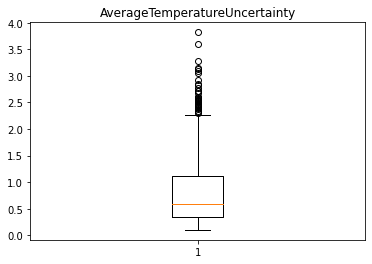

In [19]:
plt.boxplot(df['AverageTemperatureUncertainty'])
plt.title('AverageTemperatureUncertainty')
plt.show()

In [20]:
Q1 = df['AverageTemperatureUncertainty'].quantile(0.25)
Q3 = df['AverageTemperatureUncertainty'].quantile(0.75)
IQR = Q3 - Q1

inferior = df[df['AverageTemperatureUncertainty'] < (Q1 - 1.5 * IQR)]
superior = df[df['AverageTemperatureUncertainty'] > (Q3 + 1.5 * IQR)]

In [21]:
len(inferior)

0

In [22]:
len(superior)

34

Para el caso de esta variable, si se hace notar la importancia de eliminar los datos atípicos, pues el extremo superior indica que hay varios datos con mediciones muy imprecisas, los cuales pueden distorsionar el análisis.

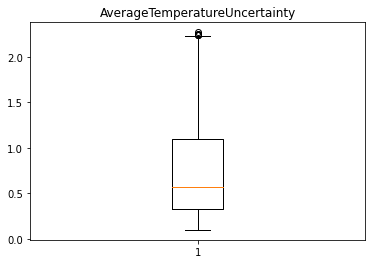

In [23]:
df.drop(superior.index, inplace=True)
    
plt.boxplot(df['AverageTemperatureUncertainty'])
plt.title('AverageTemperatureUncertainty')
plt.show()

### Comportamiento de datos

#### Normalidad de los datos

In [24]:
def show_normality(data):
    mu, std = norm.fit(data)
    plt.hist(data, bins=25, density=True, alpha=0.6, color='b')
  
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} and {:.2f}".format(mu, std)
    plt.title(title)
    
    plt.show()
    
    kurtosis = data.kurtosis()
    skew = data.skew()
    print('Kurtosis: ', kurtosis)
    print('Sesgo: ', skew)

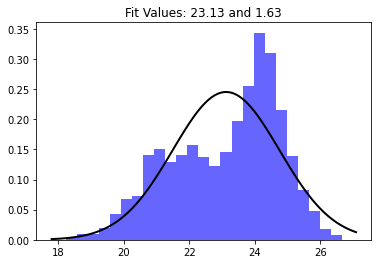

Kurtosis:  -0.7053619628966521
Sesgo:  -0.453348538444314


In [25]:
show_normality(df['AverageTemperature'])

No se puede aproximar la variable de `AverageTemperature` a una distribución normal.

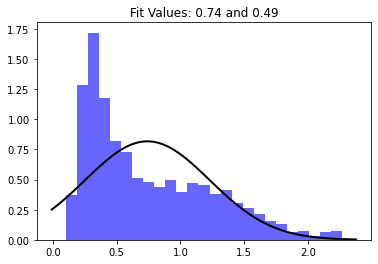

Kurtosis:  -0.1167409624296436
Sesgo:  0.8735459881046785


In [26]:
show_normality(df['AverageTemperatureUncertainty'])

La variable de `AverageTemperatureUncertainty` tampoco cumple para una distribución normal.

#### Correlación de los datos

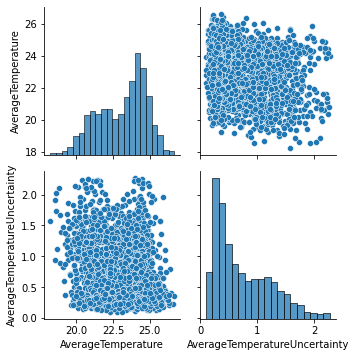

In [27]:
sns.pairplot(data=df)

<AxesSubplot:>

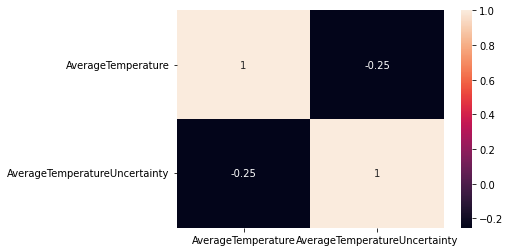

In [28]:
correlacion = df[['AverageTemperature', 'AverageTemperatureUncertainty']].corr()
fig, axis = plt.subplots()
sns.heatmap(correlacion, xticklabels=correlacion.columns, yticklabels=correlacion.columns, annot=True, ax=axis)

Se puede observar que no hay correlación entre las variables númericas estudiadas.

#### Lugares con temperaturas más extremas

In [29]:
avg_temp_by_country = df.groupby('Country').mean()\
    .sort_values(by=['AverageTemperature'])

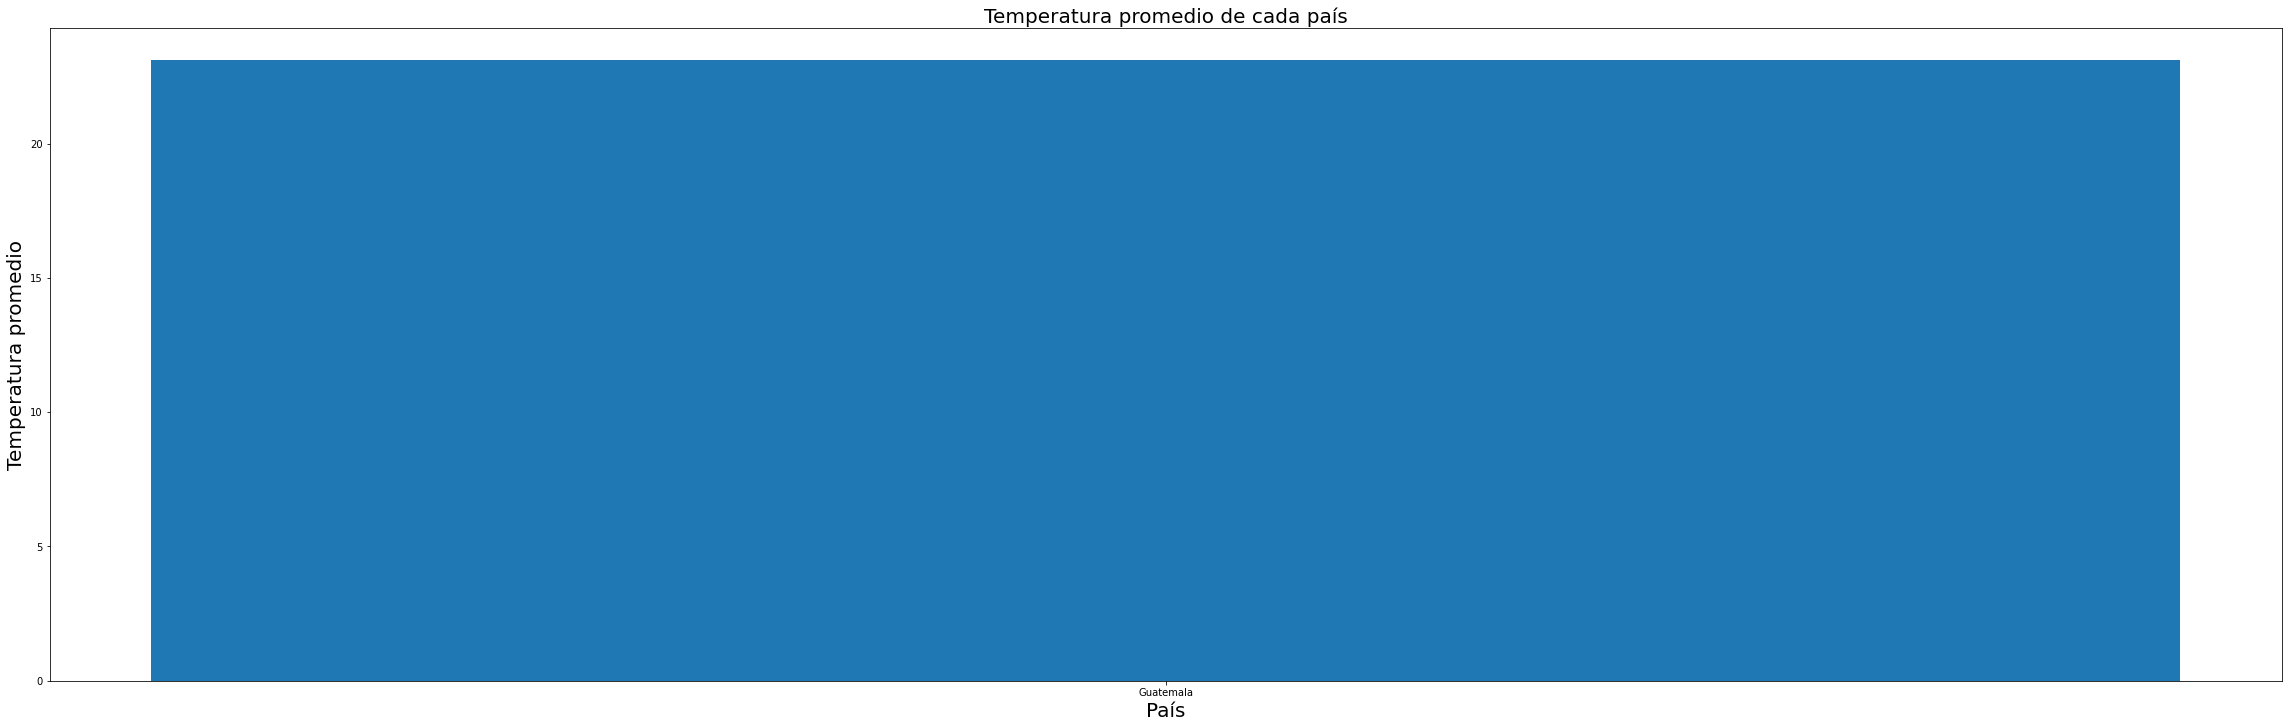

In [30]:
plt.figure(figsize=(40,12))
plt.bar(
    avg_temp_by_country.index,
    avg_temp_by_country['AverageTemperature']
)
plt.title('Temperatura promedio de cada país', size=20)
plt.xlabel('País', size=20)
plt.ylabel('Temperatura promedio', size=20)
plt.show()

Top 5 lugares con temperaturas más bajas:

In [31]:
avg_temp_by_country.head()

,AverageTemperature,AverageTemperatureUncertainty
Country,,
Guatemala,23.126149,0.741243


Top 5 lugares con temperaturas más altas:

In [32]:
avg_temp_by_country.tail()

,AverageTemperature,AverageTemperatureUncertainty
Country,,
Guatemala,23.126149,0.741243


De lo más destacable en este punto es que los países más calurosos no difieren de forma extrema a la temperatura promedio del resto de países. Por el otro lado, los países más frios son más escasos, y con temperaturas más extremas en comparación a los demás.

## 2. Serie univariante por la variable AverageTemperature

### a. Especifique Inicio, fin, y frecuencia.

- **Inicio**: Año 2000, debido a que conocemos que en los últimos años la temperatura ha incremendado a un ritmo sin precedentes, por lo que la información de años anteriores ya no resulta muy útil.
- **Fin**: 2013 (año más reciente con datos disponibles)
- **Frecuencia**: Mensual

In [33]:
temp_serie = df[['dt', 'AverageTemperature']]\
    .loc[df['dt'] > '2000']
temp_serie

,dt,AverageTemperature
220167,2000-01-01,20.705
220168,2000-02-01,21.753
220169,2000-03-01,23.972
220170,2000-04-01,25.034
220171,2000-05-01,24.960
...,...,...
220327,2013-05-01,25.704
220328,2013-06-01,25.048
220329,2013-07-01,24.588
220330,2013-08-01,23.996


### b. Haga un gráfico de la serie y explique qué información puede obtener a primera vista.

In [34]:
temp_serie = temp_serie[['dt', 'AverageTemperature']].groupby('dt').mean()\
    .sort_values(by=['AverageTemperature'])

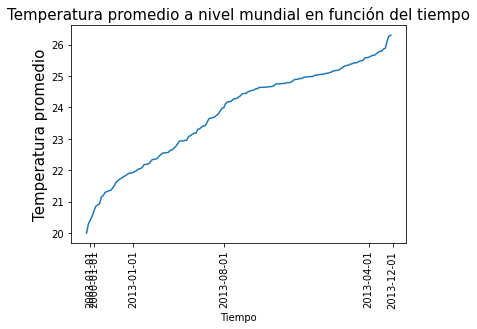

In [35]:
plt.plot(
    temp_serie.index,
    temp_serie['AverageTemperature']
)
plt.title('Temperatura promedio a nivel mundial en función del tiempo', size=15)
plt.xlabel('Tiempo')
plt.ylabel('Temperatura promedio', size=15)
plt.xticks(
    ['2000-01-01', '2003-01-01', '2013-01-01', '2013-04-01', '2013-08-01', '2013-12-01'],
    rotation=90
)
plt.show()

Se puede observar que a traves de los años la temperatura promedio a ido aumentando y que puede dar a entender que en un futuro no llegaría a reducirse.

### c. Descomponga la serie en sus componentes. Teniendo en cuenta el diagrama de la serie y sus componentes discuta si es posible hablar de estacionalidad.

No se puede observar estacionalidad, pues no se identifican patrones que se repitan año tras año. De los componentes que se observan, se puede notar que la serie de datos tiene una tendencia a crecer.

### d. Determine si es necesario transformar la serie. Explique.

Dado que no se encontró estacionalidad en los datos, es válido suponer que es necesario transformar la serie, sin embargo, dadas las suposiciones del análisis exploratorio y conocimientos generales, se sabe que la temperatura global en los últimos años ha aumentado significativamente cambiando patrones naturales habituales. Por lo tanto, la serie de datos actual cumple con dichas suposiciones,por lo que no requiere transformación.

### e. Una   vez   analizada   la   serie,   elija   los  parámetros   p,   q   y   d   del   modelo   ARIMA   o SARIMA 

In [36]:
p = 1
q = 1
d = 0 # ya es estacionaria

### f. Haga varios modelos SARIMA, y diga cuál es el mejor de ellos para estimar los datos de la serie.

Se utilizará ARIMA dado que no se encontró estacionalidad en los datos.

In [37]:
encontrar_mejor_solucion(temp_serie, 'TS Temperatura', metodo = "promedio")

NameError: name 'encontrar_mejor_solucion' is not defined

### g. Haga un modelo usando el algoritmo Prophet de Facebook. Compárelo con los modelos del inciso anterior. ¿Cuál funcionó mejor?

Se necesita cambiar el tipo de dato de la variable tiempo del dataframe a tipo "datetime"

In [38]:
df.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
Country                           object
dtype: object

In [39]:
df['dt'] = pd.DatetimeIndex(df['dt'])
df.dtypes

dt                               datetime64[ns]
AverageTemperature                      float64
AverageTemperatureUncertainty           float64
Country                                  object
dtype: object

Prophet tambien necesita que los nombres se cambien, la variable de tiempo al nombre "ds" y la variable a predecir a "y".

In [40]:
df1 = df.rename(columns={'dt': 'ds',
                        'AverageTemperature': 'y'})
df1.head()

,ds,y,AverageTemperatureUncertainty,Country
218067,1825-01-01,21.204,1.770,Guatemala
218068,1825-02-01,21.584,1.374,Guatemala
218069,1825-03-01,23.038,1.704,Guatemala
218070,1825-04-01,25.276,1.923,Guatemala
218071,1825-05-01,24.995,1.276,Guatemala


Instanciamos un objeto de la Clase Prophet

In [41]:
# Fijamos un intervalo de incertidumbre de 0.95
model = Prophet(interval_width = 0.95)

Ajustamos el módelo

In [42]:
model.fit(df1)

21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:41 - cmdstanpy - INFO - Chain [1] done processing


## 3. Haga una predicción de los valores de la serie para los últimos 3 años. Explique qué tan buena es su predicción.

In [43]:
temp_s1 = df1.loc[df1["ds"].between('2011-01-1', '2013-12-31')]
temp_s1

,ds,y,AverageTemperatureUncertainty,Country
220299,2011-01-01,21.872,0.323,Guatemala
220300,2011-02-01,22.565,0.209,Guatemala
220301,2011-03-01,23.530,0.230,Guatemala
220302,2011-04-01,25.419,0.402,Guatemala
220303,2011-05-01,26.295,0.379,Guatemala
220304,2011-06-01,25.274,0.341,Guatemala
220305,2011-07-01,24.650,0.408,Guatemala
220306,2011-08-01,25.087,0.398,Guatemala
220307,2011-09-01,24.659,0.327,Guatemala
220308,2011-10-01,22.699,0.223,Guatemala


In [56]:
prediccion = model.predict(temp_s1)

In [45]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2011-01-01,21.369948,20.228735,22.439932
1,2011-02-01,22.263182,21.185431,23.356265
2,2011-03-01,23.893373,22.804260,25.042741
3,2011-04-01,25.252345,24.063046,26.371595
4,2011-05-01,26.019396,24.953691,27.123152


## 4. Haga una predicción, tres años al futuro, usando los años anteriores y determine qué tan apegada es a la realidad teniendo en cuenta los meses pasados del año actual.

In [46]:
model2 = Prophet(interval_width = 0.95)
model2.fit(temp_s1)

21:22:55 - cmdstanpy - INFO - Chain [1] start processing
21:22:55 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
fechas_futuras = model2.make_future_dataframe(periods=36, freq='MS')
fechas_futuras.tail()

,ds
64,2016-05-01
65,2016-06-01
66,2016-07-01
67,2016-08-01
68,2016-09-01


In [48]:
prediccion = model2.predict(fechas_futuras)

In [49]:
prediccion[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
64,2016-05-01,25.887997,25.379613,26.374820
65,2016-06-01,25.392967,24.911538,25.884077
66,2016-07-01,24.861095,24.406896,25.327790
67,2016-08-01,24.476664,24.005081,24.964960
68,2016-09-01,25.230238,24.683601,25.705145


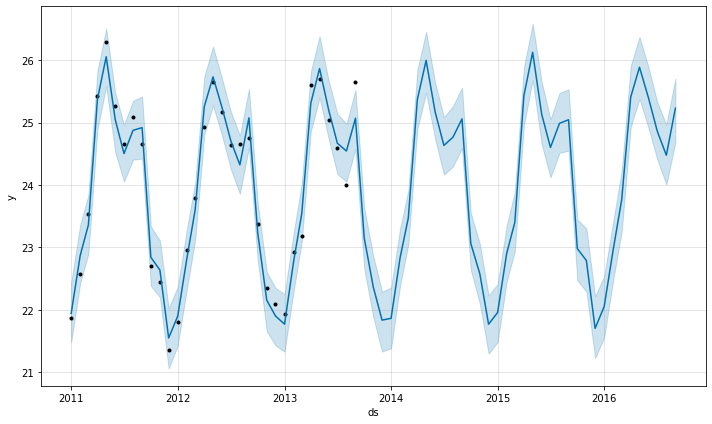

In [50]:
model2.plot(prediccion,
               uncertainty=True);

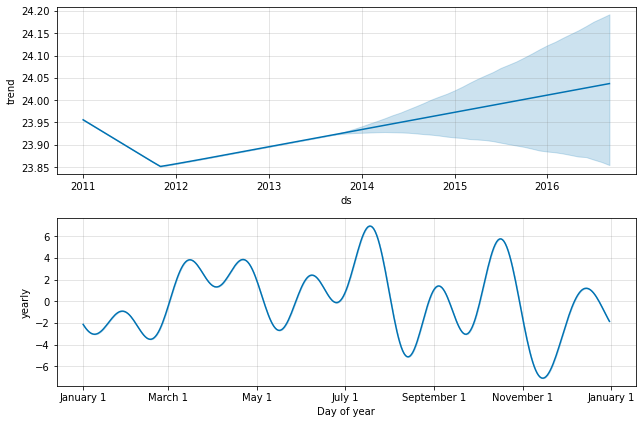

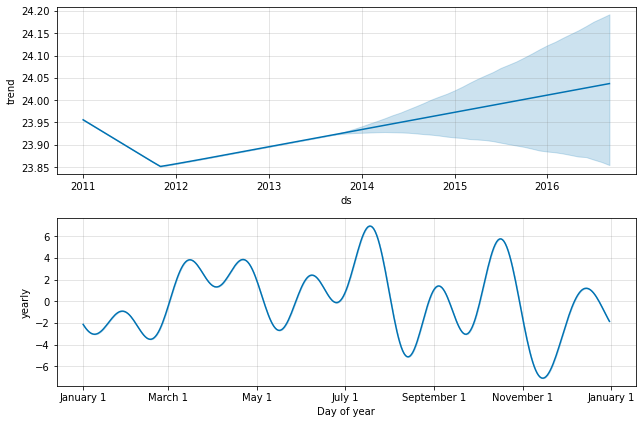

In [51]:
model2.plot_components(prediccion)

## 5. Basado en los resultados obtenidos, diría Ud que hay evidencia para corroborar la tan discutida aseveración de que el Cambio Climático y el Calentamiento Global es real